In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import shap

import warnings
warnings.filterwarnings("ignore")

# %pip install -q ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Model Training For Each CVD Category

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_triangular_heatmap(data, features, drop_cols=None, filter_no_treatment=True, cvd_category=None):
    """
    Plots a triangular correlation heatmap using selected features.

    Parameters:
    - data: DataFrame with numeric variables
    - features: list of feature names to include
    - drop_cols: optional list of columns to exclude from correlation matrix
    - filter_no_treatment: if True, exclude rows where data['drug']=='No_treatment' (if 'drug' column exists)
    """
    # Filter out 'No_treatment' if requested and 'drug' column exists
    if filter_no_treatment and 'drug' in data.columns:
        data = data[data['drug'] != 'No_treatment']

    # Select only the features you want
    feature_data = data[features].copy()

    # Drop any columns you want to exclude
    if drop_cols:
        feature_data = feature_data.drop(columns=drop_cols, errors='ignore')

    # Compute the correlation matrix
    corr = feature_data.corr(method='pearson')  # or 'spearman', 'kendall'

    # Create mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the figure
    f, ax = plt.subplots(figsize=(16, 14))

    # Custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    sns.set_style("white")
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        annot=False,
        fmt=".2f",
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Correlation Heatmap {cvd_category}", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_cv_confusion_matrix(X, y, scaler, classifiers, cv_splits=5, cvd_category=None):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    for clf_name, clf in classifiers.items():
        cumulative_cm = np.zeros((2, 2), dtype=int)

        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)

            cm = confusion_matrix(y_test, y_pred)
            cumulative_cm += cm

        avg_cm = cumulative_cm // cv_splits
        disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm)
        disp.plot(cmap='Blues')
        plt.title(f"Avg Confusion Matrix - {clf_name} - {cvd_category}")
        plt.grid(False)
        plt.show()

In [10]:
import os
import joblib

def compute_shap_and_plot(model, X_for_shap, clf_name, cvd_category):
    shap_cache_dir = "shap_cache"
    os.makedirs(shap_cache_dir, exist_ok=True)

    # Use classifier name + category for unique filename
    shap_filename = os.path.join(shap_cache_dir, f"shap_{clf_name}_{cvd_category}.joblib")

    if os.path.exists(shap_filename):
        print("Loading cached SHAP values...")
        shap_values = joblib.load(shap_filename)
    else:
        print("Computing SHAP values (this may take a while)...")
        if clf_name in ['RandomForest', 'XGB']:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_for_shap)
        else:
            pred_func = lambda x: model.predict_proba(x)[:, 1]
            explainer = shap.KernelExplainer(pred_func, shap.sample(X_for_shap, 100))
            shap_values = explainer.shap_values(X_for_shap)

        joblib.dump(shap_values, shap_filename)
        print(f"Saved SHAP values to {shap_filename}")

    # Plot
    plt.figure(figsize=(10, 6))
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_for_shap, show=False)
    else:
        shap.summary_plot(shap_values, X_for_shap, show=False)
    plt.title(f"SHAP Summary Plot - {clf_name} - {cvd_category}")
    plt.tight_layout()
    plt.show()

In [11]:
def run_cvd_pipeline(cvd_category):
    print(f"\n=== Processing {cvd_category} ===")

    # Load data
    df = pd.read_csv(f"C:/Users/Yahya/Documents/GitHub/Internship/CSV_files/diag_final_{cvd_category}.csv").drop(columns=['cml_date', 'cvd_date', 'Unnamed: 0'], errors='ignore')
    df = df.drop_duplicates()

    # Merge patient info
    patient_info = pd.read_csv("C:/Users/Yahya/Documents/GitHub/Internship/CSV_files/patients_info_table.csv")
    df = df.merge(patient_info[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})
    df = df.drop_duplicates(subset=['subject_id'])

    # Add drug label
    drug_cols = ['Cabozantinib', 'Crizotinib', 'Dasatinib', 'Imatinib', 'Nilotinib', 'Ruxolitinib']
    def list_drugs(row):
        taken = [drug for drug in drug_cols if row.get(drug, 0) >= 1]
        return ', '.join(taken) if taken else 'No_treatment'
    df['drug'] = df.apply(list_drugs, axis=1)

    # Combine drug categories
    no_treatment = df.loc[df[drug_cols].sum(axis=1) == 0, 'subject_id']
    no_treatment_df = df.loc[df['subject_id'].isin(no_treatment)].copy()
    no_treatment_df['drug'] = 'No_treatment'
    df = pd.concat([df, no_treatment_df], ignore_index=True).drop_duplicates()

    print(f"\n=== Interactive Plots for {cvd_category} ===")

    # Interactive plots
    df_drugs_grouped_nt = df[df['drug'] != 'No_treatment'].copy()
    df_drugs_grouped_nt = df_drugs_grouped_nt.groupby(['subject_id', 'drug']).mean(numeric_only=True).reset_index()
    for col in ['gender', 'anchor_age']:
        df_drugs_grouped_nt[col] = df_drugs_grouped_nt.groupby(['subject_id', 'drug'])[col].first().values

    def dist_plot(feature_list, data):
        for each_feature in feature_list:
            plt.figure(figsize=(7, 5))
            sns.histplot(data=data, x=each_feature, hue='drug', kde=True)
            plt.title(f"{each_feature}" + " " + f"{cvd_category}", fontsize=15)
            plt.tight_layout()
            plt.show()

    feature_options = [
        'anchor_age', 'mean_bmi', 'mean_systolic', 'mean_diastolic',
        'prescribed_dose', 'doses_per_24_hrs',
        'albumin', 'bilirubin, total', 'glucose', 'urea nitrogen',
        'c-reactive protein', '% hemoglobin a1c',
        'cholesterol, total', 'alanine aminotransferase (alt)', 'lactate dehydrogenase (ld)'
    ]

    widget_dist_plot = widgets.SelectMultiple(
        options=feature_options,
        value=["anchor_age"],
        layout=Layout(width='50%', height='100px'),
        description="Numerical Variable:"
    )

    def inter_dist_plot(x):
        return dist_plot(x, df_drugs_grouped_nt)

    interact(inter_dist_plot, x=widget_dist_plot);
    
    # Target label
    target_col = cvd_category
    if target_col not in df.columns:
        possible_cols = [f"has_{target_col}", f"has_{target_col}_before_cml"]
        for col in possible_cols:
            if col in df.columns:
                df[target_col] = df[col]
                break

    df[target_col] = df[[col for col in df.columns if target_col in col]].max(axis=1)

    # Feature selection
    lab_features = ['alanine aminotransferase (alt)', 'albumin', 'bilirubin, total', 'glucose', 'urea nitrogen',
                    'cholesterol, total', 'c-reactive protein', '% hemoglobin a1c', 'lactate dehydrogenase (ld)']
    vital_features = ['mean_bmi', 'mean_systolic', 'mean_diastolic', 'anchor_age']
    meta_features = ['gender', 'doses_per_24_hrs', 'duration_med']
    features = lab_features + vital_features + meta_features + drug_cols

    # Clean data
    df = df.dropna(subset=[target_col])
    df = df.dropna(subset=features, thresh=int(0.8 * len(features)))
    df[features] = df[features].apply(pd.to_numeric, errors='coerce')

    print(f"\n=== Heatmap of Features from {cvd_category} data ===")

    # Heatmap
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    plot_triangular_heatmap(df, numeric_cols, filter_no_treatment=True, cvd_category=cvd_category)

    # Pairplot
    print(f"\n=== Pairplot of Features from {cvd_category} ===")

    plot_df = df[[*vital_features, target_col]].copy()
    plot_df[target_col] = plot_df[target_col].astype('int64')
    plot_df = plot_df.dropna()

    sample_size = min(200, len(plot_df))
    plot_df = plot_df.sample(n=sample_size, random_state=42)

    sns.pairplot(plot_df, hue=target_col, diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.suptitle(f"Pairplot of Features - {cvd_category}", y=1.02)
    # plt.tight_layout()
    plt.show()

    # Imputation
    X = df[features]
    y = df[target_col]
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    imputer = KNNImputer(n_neighbors=5)
    X_imputed = imputer.fit_transform(X_scaled)
    X_imputed = pd.DataFrame(scaler.inverse_transform(X_imputed), columns=X.columns)

    # Resampling
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_imputed, y)

    # Modeling
    scale_pos_weight = (y_res == 0).sum() / (y_res == 1).sum()
    classifiers = {
        'LogReg': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
        'SVM_RBF': SVC(kernel='rbf', class_weight='balanced'),
        'XGB': XGBClassifier(n_estimators=100, use_label_encoder=False, scale_pos_weight=scale_pos_weight)
    }

    scoring = {
        'Accuracy': 'accuracy',
        'Precision': 'precision',
        'Recall': 'recall',
        'AUC': 'roc_auc'
    }

    results = {}
    for clf_name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])
        scores = cross_validate(pipeline, X_res, y_res, scoring=scoring, cv=5)
        results[clf_name] = {metric: (np.mean(vals), np.std(vals)) for metric, vals in scores.items()}
    
    # After model training loop:
    roc_fig, ax = plt.subplots(figsize=(8, 6))
    results = {}

    for clf_name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])
        scores = cross_validate(pipeline, X_res, y_res, scoring=scoring, cv=5, return_estimator=True)
        results[clf_name] = {
            metric: (np.mean(vals), np.std(vals))
            for metric, vals in scores.items() if metric != 'estimator'
        }

        # Get out-of-fold predicted probabilities for ROC
        if hasattr(clf, "predict_proba"):
            y_score = cross_val_predict(pipeline, X_res, y_res, cv=5,
                                        method='predict_proba', n_jobs=-1)[:, 1]
        else:
            # For classifiers without predict_proba, use decision_function
            y_score = cross_val_predict(pipeline, X_res, y_res, cv=5,
                                        method='decision_function', n_jobs=-1)

        fpr, tpr, _ = roc_curve(y_res, y_score)
        ax.plot(fpr, tpr, label=f"{clf_name} (AUC = {auc(fpr, tpr):.2f})")

    # Final ROC plot formatting

    print(f"\n=== ROC curves for {cvd_category} ===")

    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_title(f"ROC Curves - {cvd_category.upper()}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Display

    print(f"\n=== Model Results for {cvd_category} ===")

    for clf_name, scores in results.items():
        print(f"\n{clf_name} Results:")
        for metric, (mean_val, std_val) in scores.items():
            print(f"  {metric}: {mean_val:.3f} ± {std_val:.3f}")
    
    # Confusion Matrices

    print(f"\n=== Confusion Matrices for {cvd_category} ===")

    plot_cv_confusion_matrix(X_res, y_res, scaler, classifiers, cvd_category=cvd_category)

    # SHAP Values

    print(f"\n=== SHAP Values for {cvd_category} ===")

    pipeline.fit(X_res, y_res)
    model = pipeline.named_steps['classifier']

    # Use the original feature set with column names for SHAP input
    X_for_shap = pipeline.named_steps['scaler'].transform(X_imputed)
    X_for_shap = pd.DataFrame(X_for_shap, columns=X_imputed.columns)

    compute_shap_and_plot(model, X_for_shap, clf_name, cvd_category)



=== Processing pulmonary ===

=== Interactive Plots for pulmonary ===


interactive(children=(SelectMultiple(description='Numerical Variable:', index=(0,), layout=Layout(height='100p…


=== Heatmap of Features from pulmonary data ===


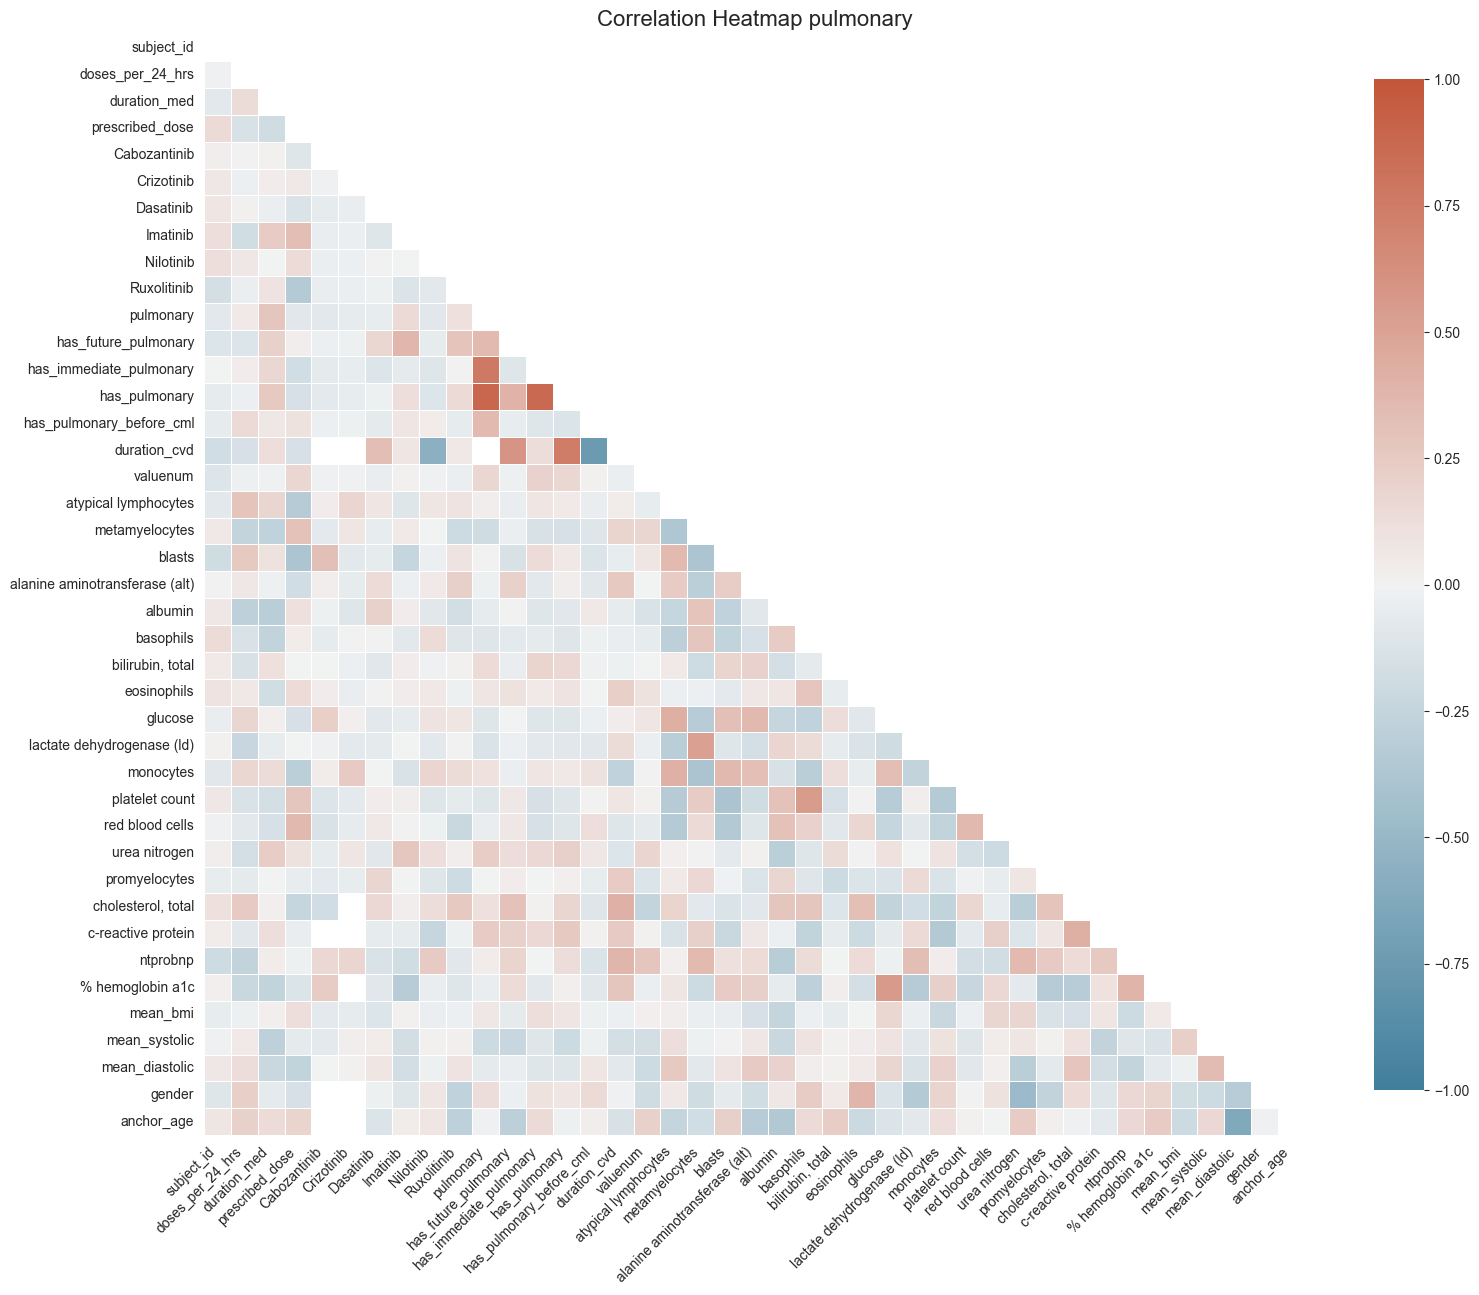


=== Pairplot of Features from pulmonary ===


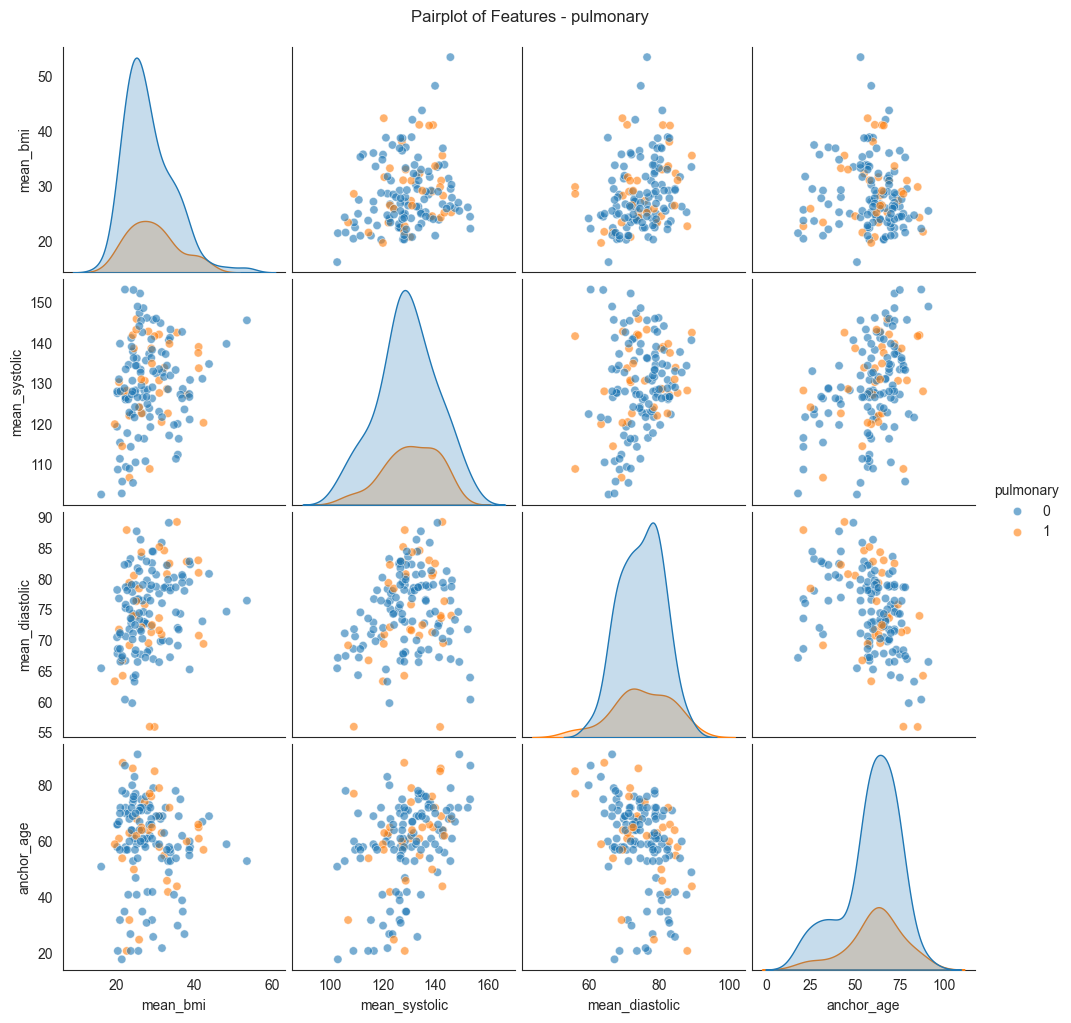


=== ROC curves for pulmonary ===


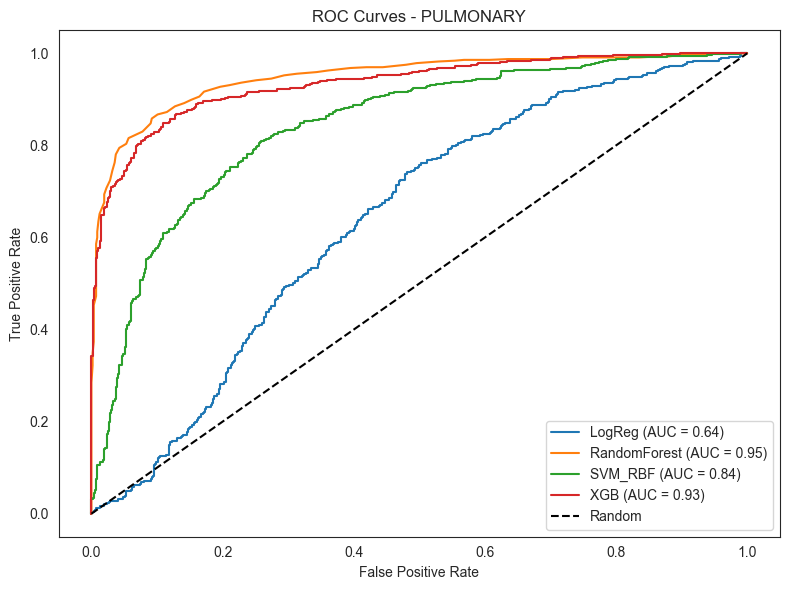


=== Model Results for pulmonary ===

LogReg Results:
  fit_time: 0.004 ± 0.000
  score_time: 0.004 ± 0.000
  test_Accuracy: 0.617 ± 0.021
  test_Precision: 0.609 ± 0.015
  test_Recall: 0.651 ± 0.052
  test_AUC: 0.645 ± 0.039

RandomForest Results:
  fit_time: 0.173 ± 0.003
  score_time: 0.011 ± 0.000
  test_Accuracy: 0.870 ± 0.057
  test_Precision: 0.861 ± 0.025
  test_Recall: 0.880 ± 0.108
  test_AUC: 0.945 ± 0.052

SVM_RBF Results:
  fit_time: 0.013 ± 0.000
  score_time: 0.017 ± 0.000
  test_Accuracy: 0.769 ± 0.054
  test_Precision: 0.739 ± 0.040
  test_Recall: 0.828 ± 0.095
  test_AUC: 0.845 ± 0.065

XGB Results:
  fit_time: 0.042 ± 0.001
  score_time: 0.007 ± 0.000
  test_Accuracy: 0.865 ± 0.074
  test_Precision: 0.861 ± 0.010
  test_Recall: 0.871 ± 0.171
  test_AUC: 0.940 ± 0.064

=== Confusion Matrices for pulmonary ===


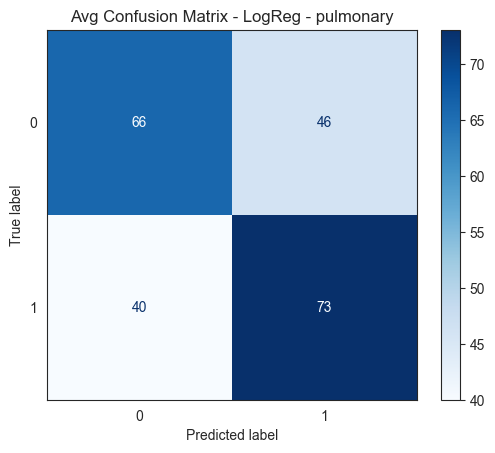

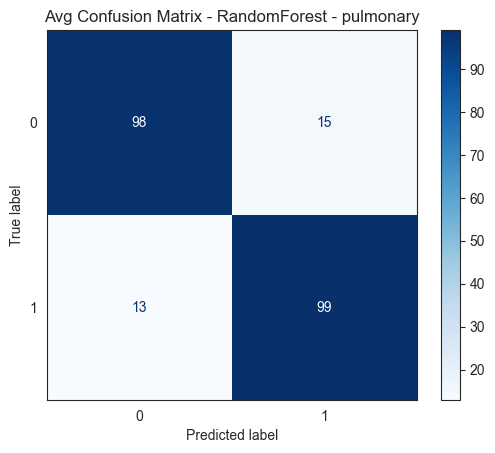

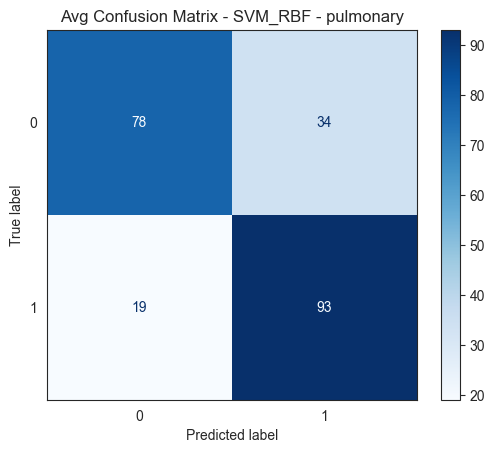

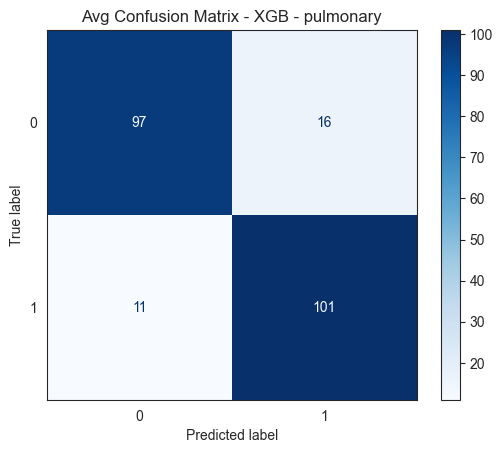


=== SHAP Values for pulmonary ===
Computing SHAP values (this may take a while)...
Saved SHAP values to shap_cache\shap_XGB_pulmonary.joblib


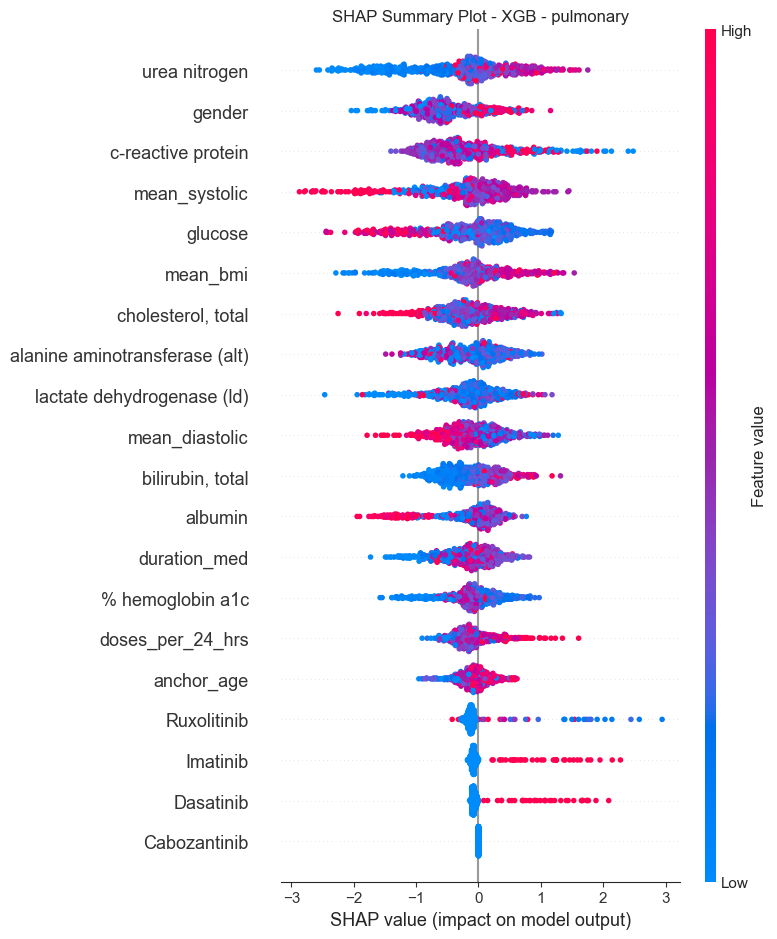

In [18]:
run_cvd_pipeline('pulmonary')